<a href="https://colab.research.google.com/github/avishek-astra/Deep_Learning_Experiments/blob/main/FFN_weightsHistogram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
#import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

Import dataset

In [60]:
# import dataset (comes with colab!)
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

In [61]:
# extract labels (number IDs) and remove from data
labels = data[:,0]
data = data[:,1:]

#normalize the data to a range of [0,1]
dataNorm = data / np.max(data)


Confirm that the data have limited values

Create train/TEST GROUPS USING DataLoader

In [62]:
# Step 1: convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long() # long = int64

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)

#Reminder:
# 0) normalize train to [0 1] and test to [0 1]
# 1) normalize train to [0 1] and test to [0 255]
# 2) normalize train to [0 255] and test to [0 1]
train_data=train_data/torch.max(train_data)
test_data=test_data/torch.max(test_data)

# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [63]:
#check all variables in workspace
%whos

Variable                 Type             Data/Info
---------------------------------------------------
DataLoader               type             <class 'torch.utils.data.dataloader.DataLoader'>
F                        module           <module 'torch.nn.functio<...>/torch/nn/functional.py'>
TensorDataset            type             <class 'torch.utils.data.dataset.TensorDataset'>
ax                       ndarray          2: 2 elems, type `object`, 16 bytes
batchsize                int              32
createTheMNISTNet        function         <function createTheMNISTNet at 0x7e73f1260360>
data                     ndarray          20000x784: 15680000 elems, type `float64`, 125440000 bytes (119.62890625 Mb)
dataNorm                 ndarray          20000x784: 15680000 elems, type `float64`, 125440000 bytes (119.62890625 Mb)
dataT                    Tensor           tensor([[0., 0., 0.,  ...<...>, 0.,  ..., 0., 0., 0.]])
fig                      Figure           Figure(1500x500)
function2

Create the DL model

In [64]:
def createTheMNISTNet():
  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()
      ###input layer
      self.input = nn.Linear(784,64)
      ###hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)
      ###output layer
      self.output = nn.Linear(32,10)
    #forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return self.output(x)
      # NEW HERE: log-softmax the output, because I'm using NLLLoss instead of CrossEntropyLoss
  #create the model instance
  net = mnistNet()
  #loss function
  lossfun = nn.CrossEntropyLoss()
  #optimizer
  optimizer = torch.optim.SGD(net.parameters(),lr=.01)
  return net,lossfun, optimizer

Exploring the innards of the model

summary of the entire model
mnistNet(
  (input): Linear(in_features=784, out_features=64, bias=True)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=10, bias=True)
)
 
Summary of input layers
{'training': True, '_parameters': {'weight': Parameter containing:
tensor([[-0.0019,  0.0050,  0.0200,  ..., -0.0120,  0.0168,  0.0033],
        [-0.0296,  0.0191,  0.0135,  ...,  0.0103, -0.0069, -0.0091],
        [-0.0040,  0.0059,  0.0336,  ...,  0.0032, -0.0255, -0.0098],
        ...,
        [ 0.0032, -0.0216, -0.0086,  ..., -0.0027, -0.0145, -0.0302],
        [-0.0247, -0.0179, -0.0053,  ..., -0.0062,  0.0336,  0.0129],
        [ 0.0052,  0.0071, -0.0073,  ...,  0.0175, -0.0327, -0.0250]],
       requires_grad=True), 'bias': Parameter containing:
tensor([ 0.0036, -0.0035,  0.0059,  0.0200,  0.0346,  0.0334, -0.0126,  0.0115,
        -0.0011, -0.0012,  0.0244, -0.0349,  0.00

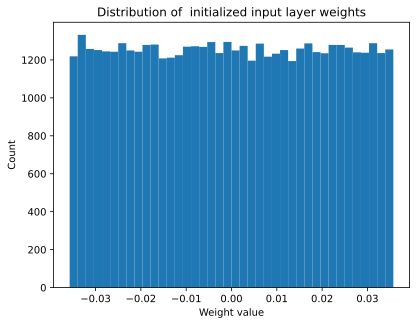

In [65]:
net=createTheMNISTNet()[0]
#summary of the entire model
print('summary of the entire model')
print(net)
print(' ')
##explore one of the layers
print('Summary of input layers')
print(vars(net.input))
print(' ')
##check out the matrix of weights
print('Input layer weights')
print(net.input.weight.shape)
print(net.input.weight)
print(' ')
##finally, extract the weights and make a histogram
w=net.input.weight.detach().flatten()
plt.hist(w,40)
plt.xlabel('Weight value')
plt.ylabel('Count')
plt.title('Distribution of  initialized input layer weights')
plt.show()

A function that returns a histogram of all weights

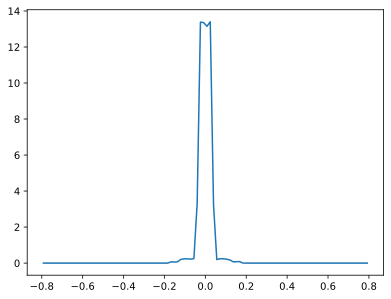

In [66]:
def weightsHistogram(net):

  # initialize weight vector
  W = np.array([])

  # concatenate each set of weights
  for layer in net.parameters():
    W = np.concatenate((W,layer.detach().flatten().numpy() ))

  # compute their histogram (note: range is hard-coded)
  histy,histx = np.histogram(W,bins=np.linspace(-.8,.8,101),density=True)
  histx = (histx[1:]+histx[:-1])/2
  return histx,histy
# test it!
histx,histy = weightsHistogram(net)
plt.plot(histx,histy);

Create a function that trains the model

In [67]:
# a function that trains the model
def function2trainTheModel():
  #number of epocs
  numepochs=60
  #create a new model
  net,lossfun,optimizer=createTheMNISTNet()
  #initialize losses
  losses=torch.zeros(numepochs)
  trainAcc=[]
  testAcc=[]
    # Run the weightsHistogram function once to get the size of histy
  temp_histx, temp_histy = weightsHistogram(net)
  hist_size = len(temp_histy)
  # Initialize histy as a 2D numpy array to store histograms for each epoch
  histy = np.zeros((numepochs, hist_size))
  #loop over epochs
  for epochi in range(numepochs):
    #get the weights distributions at the start of this epoch
    histx, current_histy = weightsHistogram(net) # Get the current epoch's histogram
    histy[epochi,:] = current_histy
    #loop over training data batches
    batchAcc=[]
    batchLoss=[]
    for X,y in train_loader:
      #forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)
      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)

    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net,histx,histy

Run the model and show the results

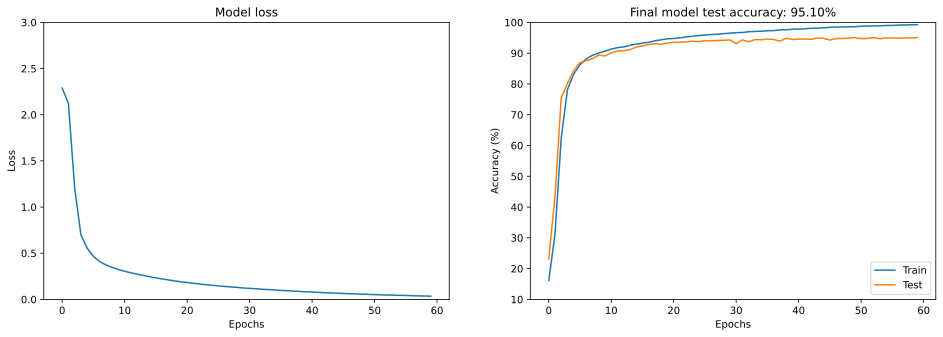

In [68]:
trainAcc,testAcc,losses,net,histx,histy = function2trainTheModel()
fig,ax=plt.subplots(1,2,figsize=(16,5))
ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')
ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()
plt.show()

Inspect the results in more detail

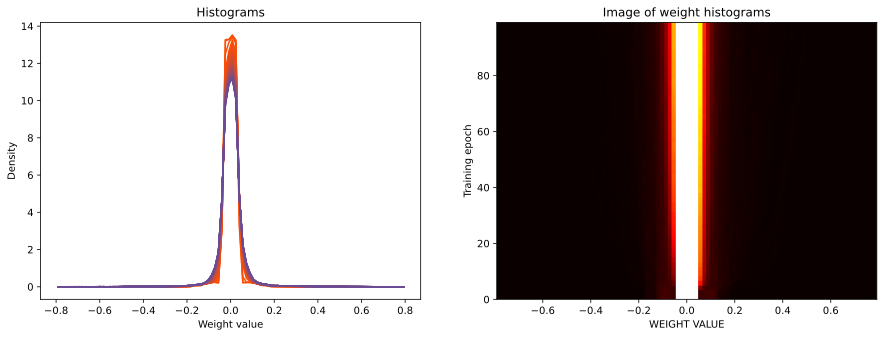

In [69]:
trainAcc,testAcc,losses,net,histx,returned_histy = function2trainTheModel() # Assign the returned histy to a different variable
histy = returned_histy # Assign the returned histy to the variable used for plotting

fig,ax=plt.subplots(1,2,figsize=(15,5))
for i in range(histy.shape[0]):
  ax[0].plot(histx,histy[i,:],color=[1-i/100,.3,i/100])
ax[0].set_xlabel('Weight value')
ax[0].set_ylabel('Density')
ax[0].set_title('Histograms')
ax[1].imshow(histy,vmin=0, vmax=3,extent=[histx[0],histx[-1],0,99],aspect='auto',origin='lower',cmap='hot')
ax[1].set_xlabel('WEIGHT VALUE')
ax[1].set_ylabel('Training epoch')
ax[1].set_title('Image of weight histograms')
plt.show()